<a href="https://colab.research.google.com/github/Luiz-sj/Projeto-Final---Bootcamp-Alura-Data-Science-2021/blob/main/Cap%C3%ADtulo_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Para encerrar o trabalho, o modelo salvo no final do capítulo anterior deve ser carregado e testado com todos os dados do data frame original. A função `treatment()` para tratamento dos dados também será definida, ela será baseada no que foi discutido na seção 1.2.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

def treatment(df):
  #Separando as features em categóricas, contínuas e de saída
  categorical_features = df.iloc[:,0:13]
  continuous_features = df.iloc[:,13:-2]
  exit_features = df.iloc[:,-2:]

  #Atualizando os valores nulos das features contínuas
  continuous_features = df.groupby('PATIENT_VISIT_IDENTIFIER', as_index=False)[continuous_features.columns].fillna(method='ffill').fillna(method='bfill')

  #Atualizando o data frame sem os valores nulos das features contínuas
  df_treated = pd.concat([categorical_features, continuous_features, exit_features], axis=1).dropna()

  #Transformando a colunas AGE_PERCENTIL de strings para valores flutuantes
  dict_ages = {'10th': 0,
              '20th': 10, 
              '30th': 20,
              '40th': 30,
              '50th': 40,
              '60th': 50,
              '70th': 60,
              '80th': 70,
              '90th': 80,
              'Above 90th': 90}

  df_treated['AGE_PERCENTIL'] = df_treated['AGE_PERCENTIL'].map(dict_ages)

  #Removendo os pacientes que já foram internados na primeira janela de tempo
  to_remove = df_treated[df_treated['WINDOW'] == '0-2'][df_treated['ICU'] == 1]['PATIENT_VISIT_IDENTIFIER'].values

  for i in df_treated.index:
    if df_treated.loc[i, 'PATIENT_VISIT_IDENTIFIER'] in to_remove:
      df_treated.drop(i, axis=0, inplace=True)

  #Criando a feature de saída ICU_norm:
  icu_norm = df_treated.groupby('PATIENT_VISIT_IDENTIFIER', as_index=True)['ICU'].sum()
  for i in icu_norm.index:
    if icu_norm[i] > 0:
      icu_norm[i] = 1

  df_treated['ICU_norm'] = 0

  for i in df_treated.index:
    df_treated.loc[i, 'ICU_norm'] = icu_norm[df_treated['PATIENT_VISIT_IDENTIFIER'][i]]  

  #Selecionando os dados relativos a primeira janela de tempo
  df_treated = df_treated[df_treated['WINDOW'] == '0-2']

  #Aplicando funções de correlação para eliminar features correlacionadas
  df_treated_corr = continuous_features.corr().abs()

  #Eliminar a diagonal principal e a matriz triangular inferior
  for i in range(0,len(df_treated_corr)):
    for j in range(0,len(df_treated_corr)):
      if i >= j:
        df_treated_corr.iloc[i,j] = 0

  #Verificar as features que apresentam correlação maior que 0.95 com as colunas anteriores
  to_remove = []
  for column in df_treated_corr.columns:
    if any(df_treated_corr[column] > 0.95):
      to_remove.append(column)

  df_treated = df_treated.drop(to_remove, axis=1)

  #Retorna o data frame tratado
  return df_treated



In [2]:
df = pd.read_excel('https://github.com/Luiz-sj/Projeto-Final---Bootcamp-Alura-Data-Science-2021/blob/main/Dados/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true')
df = treatment(df)

df

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_DIFF,FFA_MEDIAN,FFA_DIFF,GGT_MEDIAN,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_DIFF,HEMOGLOBIN_DIFF,...,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_DIFF,TGO_MEDIAN,TGO_DIFF,TGP_DIFF,TTPA_MEDIAN,TTPA_DIFF,UREA_MEDIAN,UREA_DIFF,DIMER_MEDIAN,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,WINDOW,ICU,ICU_norm
0,0,1,50,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.183673,-1.0,-0.868365,-1.0,-0.742004,-1.0,-0.945093,-1.0,-0.891993,-1.0,0.090147,-1.0,-1.0,...,-1.0,0.345679,-1.0,-0.028571,-1.0,-0.997201,-1.0,-1.0,-0.825613,-1.0,-0.836145,-1.0,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,1
10,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.357143,-1.0,-0.912243,-1.0,-0.742004,-1.0,-0.958528,-1.0,-0.780261,-1.0,0.144654,-1.0,-1.0,...,-1.0,0.345679,-1.0,0.085714,-1.0,-0.995428,-1.0,-1.0,-0.846633,-1.0,-0.836145,-1.0,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,0-2,0,1
15,3,0,30,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.972789,-1.0,-1.0,-1.0,0.326531,-1.0,-0.968861,-1.0,-0.194030,-1.0,-0.316589,-1.0,-0.891993,-1.0,-0.203354,-1.0,-1.0,...,-1.0,0.580247,-1.0,0.200000,-1.0,-0.989549,-1.0,-1.0,-0.846633,-1.0,-0.937349,-1.0,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,0
20,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.935113,-1.0,-1.0,-1.0,0.357143,-1.0,-0.913659,-1.0,-0.829424,-1.0,-0.938084,-1.0,-0.851024,-1.0,0.358491,-1.0,-1.0,...,-1.0,0.345679,-1.0,0.142857,-1.0,-0.998507,-1.0,-1.0,-0.846633,-1.0,-0.903614,-1.0,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,0-2,0,0
25,5,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.357143,-1.0,-0.891012,-1.0,-0.742004,-1.0,-0.958528,-1.0,-0.891993,-1.0,0.291405,-1.0,-1.0,...,-1.0,0.345679,-1.0,0.085714,-1.0,-0.997947,-1.0,-1.0,-0.846633,-1.0,-0.884337,-1.0,-1.000000,-1.0,-0.037037,-0.538462,-0.537736,-0.525424,-0.196429,0.815789,0.030928,-0.3750,-0.401709,

In [3]:
from joblib import dump, load

#O arquivo pode ser encontrado na pasta main do repositório
model_loaded = load('/content/model_rf_optimized.joblib')

model_loaded

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=32, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=32,
                       min_weight_fraction_leaf=0.0, n_estimators=64,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [4]:
from sklearn.metrics import accuracy_score

X = df.drop(['PATIENT_VISIT_IDENTIFIER', 'WINDOW', 'ICU', 'ICU_norm'], axis=1)
y = df['ICU_norm']
model_loaded.fit(X, y)

y_pred = model_loaded.predict(X)
accuracy_score(y, y_pred)

0.8607954545454546

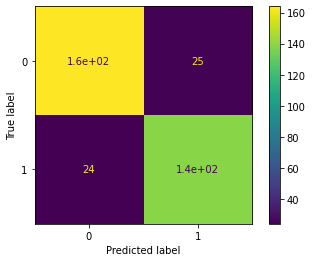

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model_loaded, X, y)

In [6]:
from sklearn.metrics import classification_report

print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       189
           1       0.85      0.85      0.85       163

    accuracy                           0.86       352
   macro avg       0.86      0.86      0.86       352
weighted avg       0.86      0.86      0.86       352



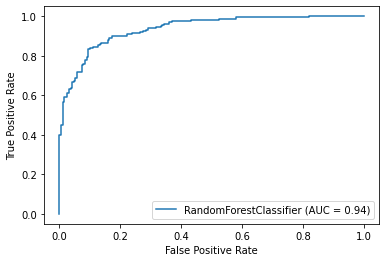

In [7]:
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score

plot_roc_curve(model_loaded, X, y)